In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download Dataset https://www.kaggle.com/datasnaek/youtube-new 

Build Model

- Predict video categories using movie comments/descriptions (either Deep learning or Sequence models).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import re
import torch
!pip install transformers
from transformers import BertTokenizer, BertModel
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from keras import backend as K
from keras.metrics import categorical_accuracy


In [ ]:
data_path = './Kaggle YouTube/'
df = pd.read_csv(data_path+'USvideos.csv')

df['description'] = df['description'].astype('str')
df['category_id'] = df['category_id'].astype('category')

### Data Description & EDA

In [ ]:
print(df.shape)
print(len(df.category_id.unique()))
df.head(5)

(40949, 16)
16


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


Text(0.5, 1.0, 'Count of each category')

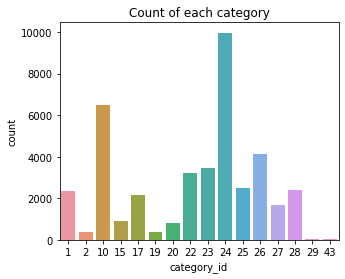

In [ ]:
sns.countplot(x="category_id", data=df)
plt.title('Count of each category')

(array([1028., 1114., 1506., 1271., 1067., 1152., 1336., 1536., 1489.,
        1433., 1474., 1369., 1279., 1211., 1009., 1032., 1216., 1033.,
        1156., 1002.,  794.,  930.,  909.,  839.,  906.,  919.,  638.,
         742.,  519.,  638.,  590.,  416.,  331.,  350.,  415.,  309.,
         322.,  278.,  346.,  360.,  270.,  365.,  263.,  228.,  187.,
         215.,  143.,  177.,  238.,  122.,  120.,  111.,   88.,  107.,
         210.,  132.,   91.,  107.,  110.,   98.,  122.,   54.,   22.,
          68.,   25.,  106.,   47.,   42.,   30.,   38.,   62.,   35.,
          19.,    9.,   32.,   16.,   33.,   17.,   32.,   19.,   30.,
          39.,   34.,   32.,   13.,   18.,   35.,   12.,   22.,    0.,
          13.,    9.,   20.,   24.,   52.,   29.,    0.,   30.,   61.,
           2.]),
 array([1.00000e+00, 5.22200e+01, 1.03440e+02, 1.54660e+02, 2.05880e+02,
        2.57100e+02, 3.08320e+02, 3.59540e+02, 4.10760e+02, 4.61980e+02,
        5.13200e+02, 5.64420e+02, 6.15640e+02, 6.66860e+

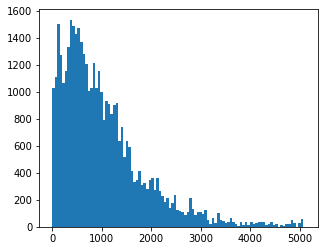

In [ ]:
desc_len = []
for i in range(len(df)):
  desc_len.append((len(df.description[i])))

plt.hist(desc_len, bins = 100)

### Processing `Description`
- remove url in a description
- use a pretrained BERT to create embeddings for descriptions: the last hidden state of the CLS token

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
def remove_url(text):
  text = re.sub(r'https?:\/\/[^ ]+', '', text)
  text = re.sub(r'  ', ' ', text)
  return text

def bert_encode(df):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
  
  # remove url
  df.description = df.description.map(lambda x: remove_url(x))

  batch_size = 64
  emb_concat = torch.Tensor([]).to(device)
  for i in range(0, len(df), batch_size):
    print(i)
    batch = df.description[i: i + batch_size]
    indexed_tokens = tokenizer.batch_encode_plus(
                          batch,
                          max_length=128, # number of tokens
                          truncation = True,
                          padding='max_length',
                          return_tensors = 'pt')['input_ids'].to(device)
    with torch.no_grad():
      emb_cls = bert_model(indexed_tokens).last_hidden_state[:,0,:].to(device)
    emb_concat = torch.cat([emb_concat, emb_cls], dim=0)
  return emb_concat

In [ ]:
bert_emb = bert_encode(df)
torch.save(bert_emb, './Kaggle YouTube/Saved Data/bert_emb.pt')
#bert_emb = torch.load('./Kaggle YouTube/Saved Data/bert_emb.pt')

In [ ]:
y = df.category_id
X = pd.DataFrame(bert_emb.cpu().numpy())
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (40949, 768) y shape: (40949,)


### Modeling
- one-hot encode labels
- 80/20 train/test split
- LSTM

In [ ]:
# one hot encode y
enc = OneHotEncoder(handle_unknown='ignore')
y_enc = enc.fit_transform(np.array(y).reshape(40949, 1)).toarray()
print('y one hot encoded shape:', y_enc.shape)

# train test split
X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, train_size=0.8, random_state = 2021)


y one hot encoded shape: (40949, 16)


In [ ]:
# reshape X_train for lstm
X_train_input = np.reshape(np.array(X_train), (X_train.shape[0], 1, X_train.shape[1]))
X_test_input = np.reshape(np.array(X_test), (X_test.shape[0], 1, X_test.shape[1]))

# lstm model
n_units = 64
batch_size = 64
optimizer = 'adam'

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(n_units, input_shape = (None, X.shape[1]), recurrent_dropout=0.7),
    keras.layers.Dense(16, activation='softmax')]
)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
print(model_lstm.summary())
history_lstm = model_lstm.fit(X_train_input, y_train_enc, epochs=100, batch_size=batch_size, validation_split=0.1)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 64)                213248    
_________________________________________________________________
dense_29 (Dense)             (None, 16)                1040      
Total params: 214,288
Trainable params: 214,288
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
461/461 [==============================] - 8s 10ms/step - loss: 1.8829 - categorical_accuracy: 0.4141 - val_loss: 1.2183 - val_categorical_accuracy: 0.6013
Epoch 2/100
461/461 [==============================] - 4s 8ms/step - loss: 1.1332 - categorical_accuracy: 0.6518 - val_loss: 0.9904 - val_categorical_accuracy: 0.6874
Epoch 3/100
461/461 [==============================] - 4s 8ms/step - loss: 0.9244 - categorical_accuracy: 0.7240 - val_loss: 0.8734 - val_categorical_accuracy: 0.7320
Ep

Test Categorical Accuracy: 0.97179484


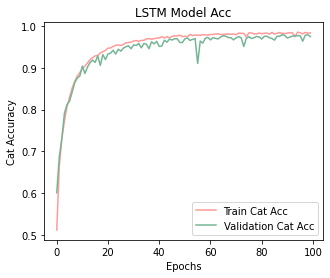

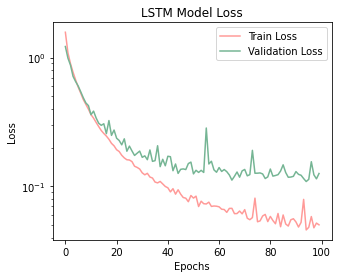

In [ ]:
def eval_model(history_model, X_test, y_test):
  # test result
  y_pred = model_lstm.predict(X_test) # in probabilities
  metric = tf.keras.metrics.CategoricalAccuracy()
  metric.update_state(y_test, y_pred)
  print("Test Categorical Accuracy:", metric.result().numpy())

  # plot accuracy
  plt.title("LSTM Model Acc")
  plt.plot(history_model.history['categorical_accuracy'], label='Train Cat Acc', color='#FF9A98')
  plt.plot(history_model.history['val_categorical_accuracy'], label='Validation Cat Acc', color='#75B594')
  plt.xlabel('Epochs')
  plt.ylabel('Cat Accuracy')
  plt.legend()
  plt.show()
  
  # plot loss
  plt.title("LSTM Model Loss")
  plt.semilogy(history_model.history['loss'], label='Train Loss', color='#FF9A98')
  plt.semilogy(history_model.history['val_loss'], label='Validation Loss', color='#75B594')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

eval_model(history_lstm, X_test_input, y_test_enc)

Average accuracy for all categories: 0.97